# **1. Importing Libraries**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

# **2. Data Loading & Inspection**

In [38]:
df = pd.read_csv(r'C:\Users\habib\Desktop\Forbes 2000 Global Companies\Forbes_2000_Companies_2025_Filled.csv')

In [39]:
print(df.dtypes)
df.head()

Rank                   int64
Company               object
Headquarters          object
Industry              object
Sales ($B)           float64
Profit ($B)          float64
Assets ($B)          float64
Market Value ($B)    float64
dtype: object


,Rank,Company,Headquarters,Industry,Sales ($B),Profit ($B),Assets ($B),Market Value ($B)
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46
2,3,ICBC,China,Banking,221.96,50.84,6688.60,251.33
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.15,104.97,645.03,1663.38
4,5,Amazon,United States,Retail and Wholesale,637.96,59.25,624.89,2005.64


In [40]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

Shape: (2000, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rank               2000 non-null   int64  
 1   Company            2000 non-null   object 
 2   Headquarters       2000 non-null   object 
 3   Industry           2000 non-null   object 
 4   Sales ($B)         2000 non-null   float64
 5   Profit ($B)        2000 non-null   float64
 6   Assets ($B)        2000 non-null   float64
 7   Market Value ($B)  2000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 125.1+ KB
None


In [41]:
print('Missinng Values:')
missing = df.isna().sum().sort_values(ascending=False)   
missing

Missinng Values:


Rank                 0
Company              0
Headquarters         0
Industry             0
Sales ($B)           0
Profit ($B)          0
Assets ($B)          0
Market Value ($B)    0
dtype: int64

In [42]:
print("Number of duplicate rows:")
df.duplicated().sum()
print('\nStats Report:')
df.describe(include='all').T

Number of duplicate rows:

Stats Report:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,2000.0,NaN,NaN,NaN,1000.331,577.430053,1.0,500.75,1000.5,1500.25,1998.0
Company,2000,2000,JPMorganChase,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Headquarters,2000,61,United States,612,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry,2000,31,Banking,326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sales ($B),2000.0,NaN,NaN,NaN,26.46143,47.915988,0.086,6.15,12.97,25.7075,680.99
Profit ($B),2000.0,NaN,NaN,NaN,2.584004,6.760348,0.003,0.589825,1.04,2.24,111.0
Assets ($B),2000.0,NaN,NaN,NaN,121.087279,395.754878,0.181,15.755,33.875,78.82,6688.6
Market Value ($B),2000.0,NaN,NaN,NaN,45.641756,154.511821,0.175,8.3075,17.205,37.3475,3143.82


### Converting monetary values into numeric types for accuracy

In [43]:
df2 = df.copy()

In [44]:
monetary_cols = ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)']
for col in monetary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

*Testing after cleaning*

In [45]:
before_num = df[monetary_cols].isna().sum()
after_num = df2[monetary_cols].isna().sum()

In [46]:
print("Before fill:\n", before_num)
print("\nAfter fill:\n", after_num)

Before fill:
 Sales ($B)           0
Profit ($B)          0
Assets ($B)          0
Market Value ($B)    0
dtype: int64

After fill:
 Sales ($B)           0
Profit ($B)          0
Assets ($B)          0
Market Value ($B)    0
dtype: int64


In [ ]:
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# **3. Feature Engineering** (KPIs)

In [47]:
df["Profit Margin"] = df["Profit ($B)"] / df["Sales ($B)"]
df["ROA"] = df["Profit ($B)"] / df["Assets ($B)"]  
df["Market to Assets"] = df["Market Value ($B)"] / df["Assets ($B)"]

In [48]:
for industry in df['Industry'].unique():
    industry_mask = df['Industry'] == industry
    for col in ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)']:
        industry_median = df.loc[industry_mask, col].median()
        df.loc[industry_mask, col] = df.loc[industry_mask, col].fillna(industry_median)

### Handling Outliers

In [49]:
def outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower = lower_bound, upper= upper_bound)

In [50]:
for col in ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)', 'Profit Margin', 'ROA', 'Market to Assets']:
    df[col] = outliers_iqr(df[col])

### Anomaly and High Profit flags (additional analysis)

In [51]:
df["Anomaly"] = np.abs(stats.zscore(df["Profit Margin"])) > 3
df["High Profit"] = (df["Profit Margin"] > df["Profit Margin"].median()).astype(int)

In [52]:
anomaly_count = df['Anomaly'].sum()
print(f"Statistical anomalies: {anomaly_count}")

Statistical anomalies: 0


*Private Equity Business Context Layer*

In [53]:
df['PE_Target_Size'] = ((df['Market Value ($B)'] >= 1) & (df['Market Value ($B)'] <= 50)).astype(int)
df['Investment_Score'] = (df['ROA'] * 0.4 + df['Profit Margin'] * 0.4 + df['Market to Assets'] * 0.2)
df['PE_Sweet_Spot'] = ((df['PE_Target_Size'] == 1) & (df['Profit ($B)'] > 0) & (df['Investment_Score'] > df['Investment_Score'].median())).astype(int)

In [54]:
pe_targets_count = df['PE_Sweet_Spot'].sum()
print(f"PE Sweet Spot companies: {pe_targets_count}")

PE Sweet Spot companies: 703


# **4. Feature Scaling for Clustering**

In [55]:
features = ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)', 'Profit Margin', 'ROA', 'Market to Assets']
x = df[features]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Optimal number of clusters (elbow method)

In [56]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

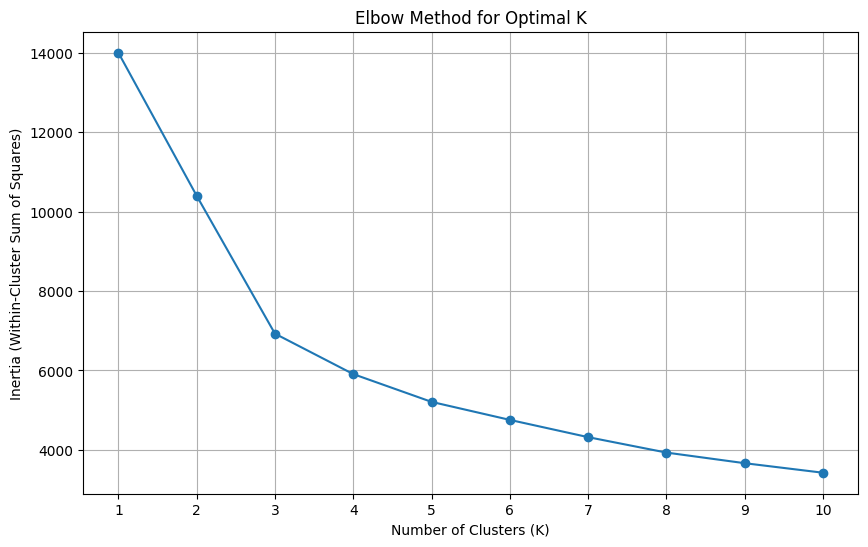

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

### based on the graph **the optimal k = 4**

### KMeans Clustering

In [58]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

In [59]:
df['Cluster'] = kmeans.fit_predict(x_scaled)
cluster_labels = {0: "Large Cap Stable", 1: "High Growth Targets", 2: "Value Opportunities", 3: "Distressed Assets"}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

In [60]:
cluster_summary = df.groupby("Cluster")[features].mean().round(2)
print("\nCluster Analysis (Mean of Features):")
print(cluster_summary.T)


Cluster Analysis (Mean of Features):
Cluster                0      1       2      3
Sales ($B)          8.81  19.45   45.45   7.55
Profit ($B)         1.62   0.82    4.19   1.21
Assets ($B)        15.44  31.30  132.56  89.07
Market Value ($B)  37.27  14.35   63.08  13.23
Profit Margin       0.22   0.05    0.13   0.19
ROA                 0.11   0.03    0.04   0.02
Market to Assets    2.45   0.62    0.82   0.21


# **5. Visualization**

## Distribution Plots

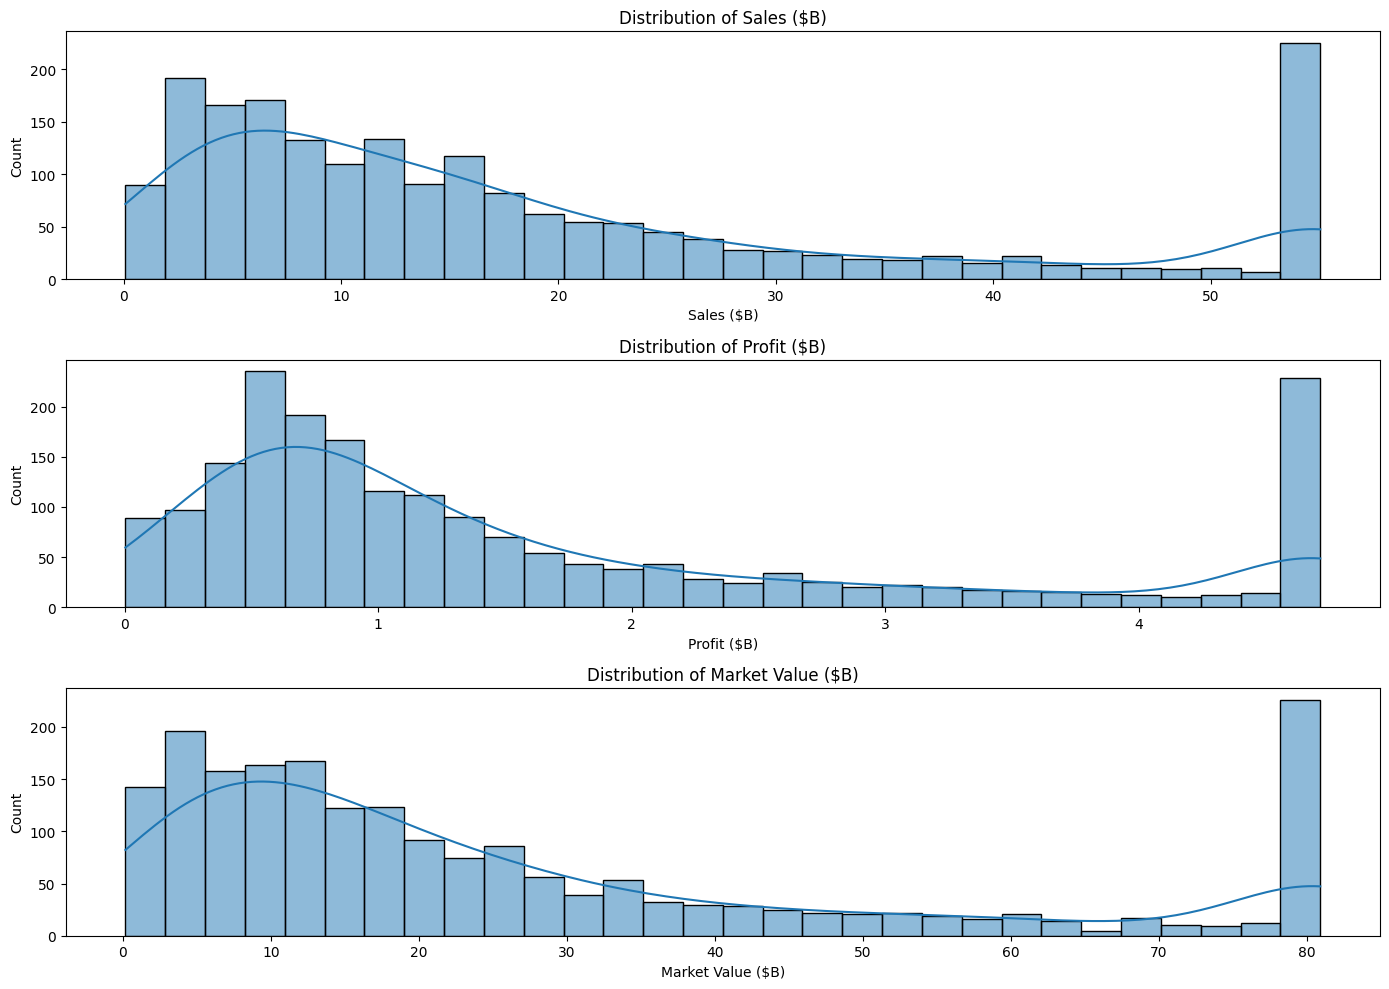

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
sns.histplot(df["Sales ($B)"], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Sales ($B)')
sns.histplot(df["Profit ($B)"], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Profit ($B)')
sns.histplot(df["Market Value ($B)"], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribution of Market Value ($B)')
plt.tight_layout()
plt.show()

## KMeans Scatter Plot

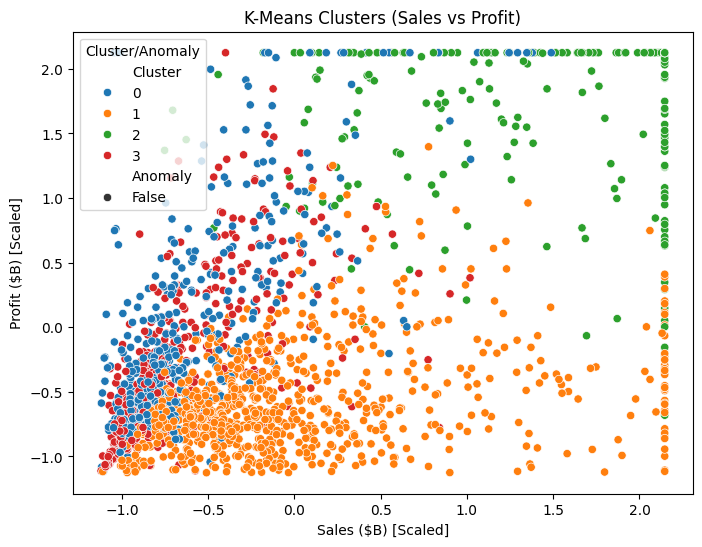

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_scaled[:, 0], y=x_scaled[:, 1], hue=df["Cluster"], palette="tab10", style=df["Anomaly"])
plt.xlabel("Sales ($B) [Scaled]")
plt.ylabel("Profit ($B) [Scaled]")
plt.title("K-Means Clusters (Sales vs Profit)")
plt.legend(title='Cluster/Anomaly')
plt.show()

## Heatmap

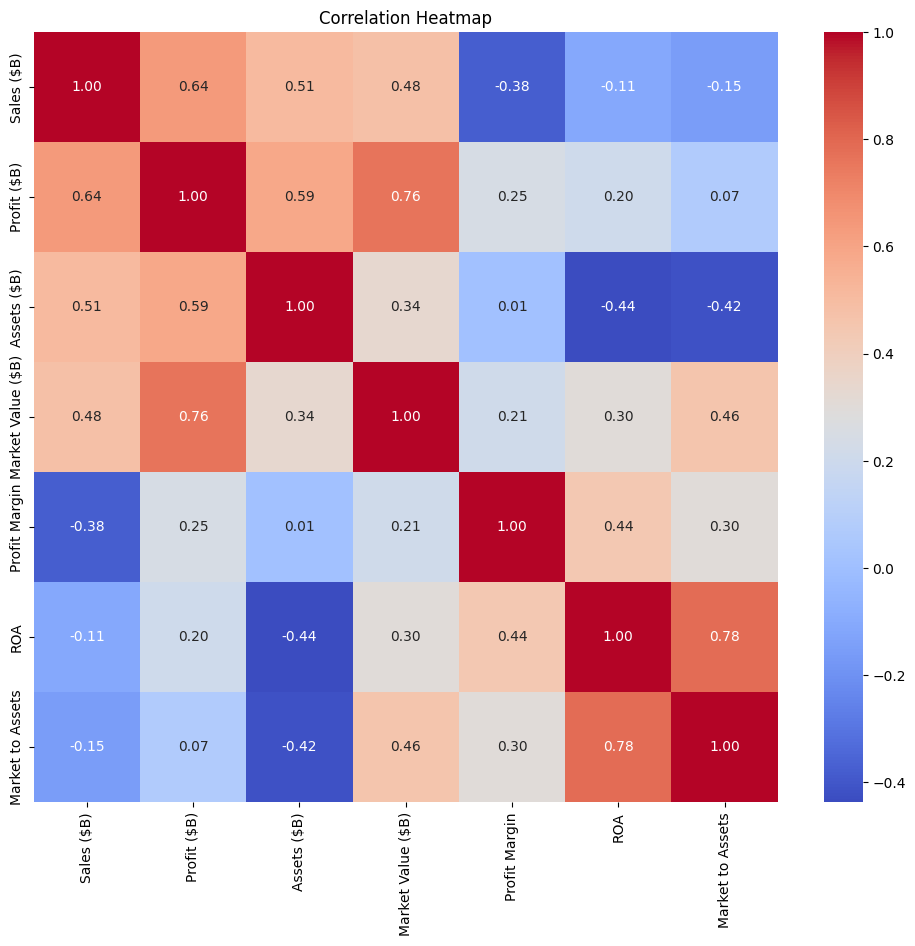

In [63]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Average Profit Margin Per Cluster

C:\Users\habib\AppData\Local\Temp\ipykernel_28844\4149401180.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Cluster", y="Profit Margin", ci=None)


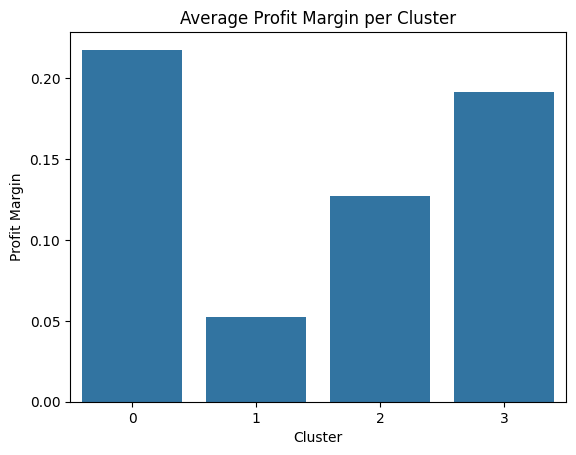

In [64]:
plt.figure()
sns.barplot(data=df, x="Cluster", y="Profit Margin", ci=None)
plt.title("Average Profit Margin per Cluster")
plt.show()

## Top 10 by Profit

C:\Users\habib\AppData\Local\Temp\ipykernel_28844\542508535.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Profit ($B)", y="Company", data=top10, palette="viridis")


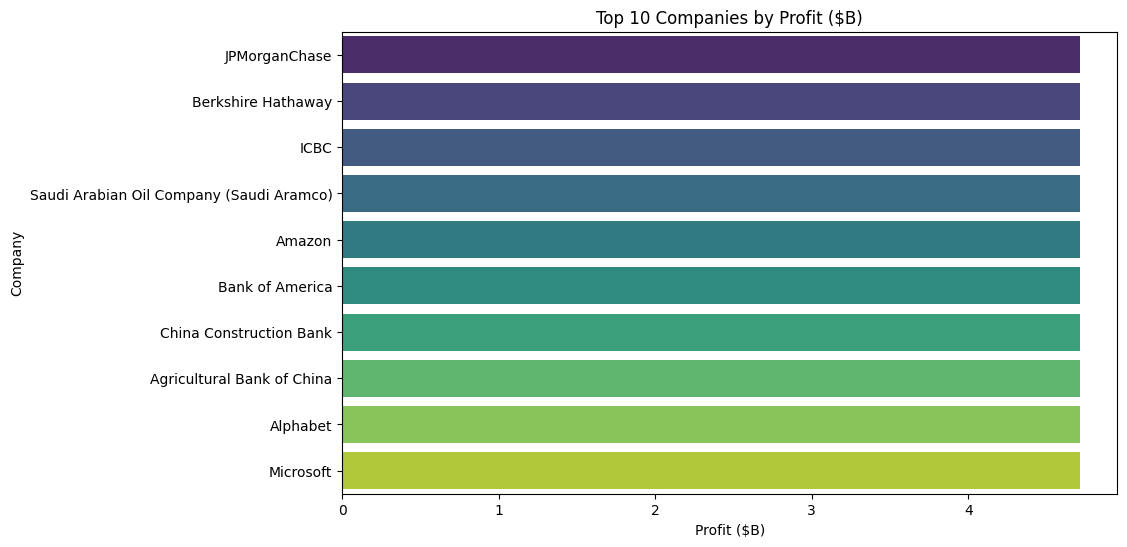

In [65]:
top10 = df.nlargest(10, "Profit ($B)")
plt.figure(figsize=(10, 6))
sns.barplot(x="Profit ($B)", y="Company", data=top10, palette="viridis")
plt.title("Top 10 Companies by Profit ($B)")
plt.show()

## Top 10 Industries

In [66]:
industry_avg = df.groupby("Industry")["Profit Margin"].mean().sort_values(ascending=False).head(10)

C:\Users\habib\AppData\Local\Temp\ipykernel_28844\2342921830.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_avg.values, y=industry_avg.index, palette="magma")


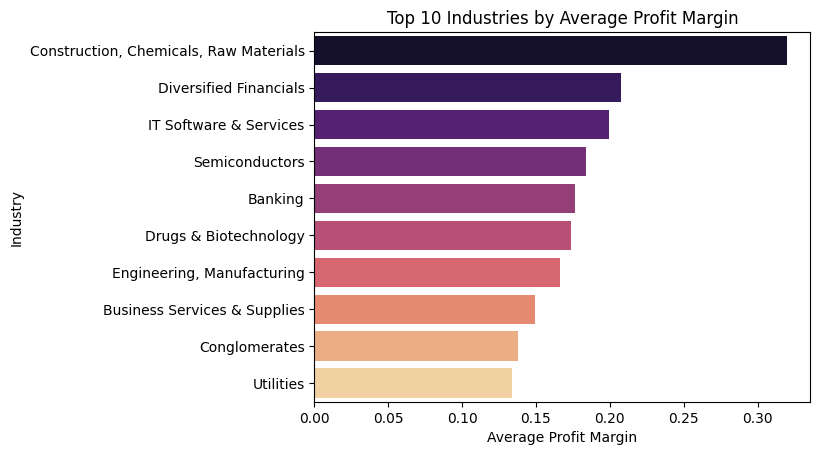

In [67]:
plt.figure()
sns.barplot(x=industry_avg.values, y=industry_avg.index, palette="magma")
plt.title("Top 10 Industries by Average Profit Margin")
plt.xlabel("Average Profit Margin")
plt.ylabel("Industry")
plt.show()

# **6. Exporting to Power BI**

In [68]:
output_path = r"C:\Users\habib\Desktop\Forbes 2000 Global Companies\Forbes_2000_Companies_2025_Final.csv"
df.to_csv(output_path, index=False)
print(f"\nFinal dataset exported successfully to: {output_path}")


Final dataset exported successfully to: C:\Users\habib\Desktop\Forbes 2000 Global Companies\Forbes_2000_Companies_2025_Final.csv
